# Exploring Raw Data with _ctapipe_

Here are just some very simplistic examples of going through and inspecting the raw data, using only the very simple pieces that are implemented right now. 

In [1]:
# some setup (need to import the things we will use later)
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.io import event_source, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u
%matplotlib inline

to read HESSIO format data, one must first make sure you install the `pyhessioxxx` module separately (currently it is not included as part of ctapipe), and make sure it is in your `PYTHONPATH`.  Then the following line will work:

In [3]:
source = event_source(get_dataset_path("gamma_test.simtel.gz"), max_events=100)
seeker = EventSeeker(source)

## looking at what is in the event

note that the R0 level is the raw data that comes out of a camera, and also the lowest level of monte-carlo data. 

You may get some warnings about times (*dubious year*), but that is only related to the fact that the Monte-Carlo data use a date that is in the future, and so this warning can be ignored

In [4]:
event = seeker[0]  # get first event
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

the event is just a class with a bunch of data items in it.  You can see a more compact represntation via:

In [5]:
print(repr(event.r0))

ctapipe.io.containers.R0Container:
                        obs_id: observation ID
                      event_id: event id number
                tels_with_data: list of telescopes with data
                        tel[*]: map of tel_id to R0CameraContainer


printing the event structure, will currently print the value all items under it (so you get a lot of output if you print a high-level container):

In [6]:
print(event.mc)

{'alt': <Angle 1.2217304706573486 rad>,
 'az': <Angle 6.283185005187988 rad>,
 'core_x': <Quantity 1129.6055908203125 m>,
 'core_y': <Quantity 547.77001953125 m>,
 'energy': <Quantity 0.3820943236351013 TeV>,
 'h_first_int': <Quantity 17846.654296875 m>,
 'shower_primary_id': 0,
 'tel': {38: {'altitude_cor': 0.0,
              'altitude_raw': 1.2217304706573486,
              'azimuth_cor': 0.0,
              'azimuth_raw': 0.0,
              'dc_to_pe': array([[ 0.15586847,  0.07887041,  0.11334796, ...,  0.09012865,
         0.09913257,  0.11362324]]),
              'pedestal': array([[ 493.32946777,  482.03399658,  460.20333862, ...,  509.96328735,
         518.74456787,  493.83590698]]),
              'photo_electron_image': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
              'reference_pulse_shape': array([[  1.37252808e-02,   1.89666748e-02,   2.69622803e-02,
          3.62854004e-02,   4.95605469e-02,   6.60400391e-02,
          8.57543945e-02,   1.12304688e-01,   1.41845

In [7]:
print(event.r0.tels_with_data)

{38, 47}


note that the event has 2 telescopes in it: 38,40... Let's try the next one:

In [8]:
event = seeker[1] # get the next event
print(event.r0.tels_with_data)

{11, 21, 118, 119, 24, 26, 61, 63}


now, we have a larger event with many telescopes... Let's look at the data from **CT24**:

In [9]:
teldata = event.r0.tel[24]
print(teldata)
teldata

{'waveform': array([[[106, 110,  96, ...,  88,  95,  84],
        [ 94,  97, 107, ...,  90,  92, 102],
        [ 97,  90,  94, ...,  90,  87,  85],
        ..., 
        [ 92,  85,  92, ...,  89,  95,  88],
        [104, 101, 103, ..., 117, 126, 127],
        [101,  99, 104, ...,  97,  97,  91]]], dtype=uint16),
 'image': array([[2945, 3013, 2951, ..., 2771, 3152, 3017]], dtype=int32),
 'num_samples': 30}


ctapipe.io.containers.R0CameraContainer:
                      image: numpy array containing integrated ADC data
                                (n_channels x n_pixels)
                   waveform: numpy array containing ADC samples(n_channels x
                                n_pixels, n_samples)
                   num_samples: number of time samples for telescope

Note that some values are unit quantities (`astropy.units.Quantity`) or angular quantities (`astropy.coordinates.Angle`), and you can easily maniuplate them:

In [10]:
event.mc.energy

<Quantity 0.3820943236351013 TeV>

In [11]:
event.mc.energy.to('GeV')

<Quantity 382.0943236351013 GeV>

In [12]:
event.mc.energy.to('J')

<Quantity 6.121825922685482e-08 J>

In [13]:
event.mc.alt

<Angle 1.2217304706573486 rad>

In [14]:
print("Altitude in degrees:", event.mc.alt.deg)

Altitude in degrees: 69.99999967119774


# Look for signal pixels
again, `event.r0.tel[x]` contains a data structure for the telescope data, with some fields like `waveform`.

Let's make a 2D plot of the sample data (sample vs pixel), so we can see if we see which pixels contain Cherenkov light signals:

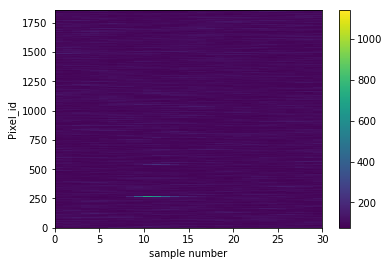

In [15]:
plt.pcolormesh(teldata.waveform[0])  # note the [0] is for channel 0
plt.colorbar()
plt.xlabel("sample number")
plt.ylabel("Pixel_id")

Let's zoom in to see if we can identify the pixels that have the Cherenkov signal in them

waveform[0] is an array of shape (N_pix,N_slice) = (1855, 30)


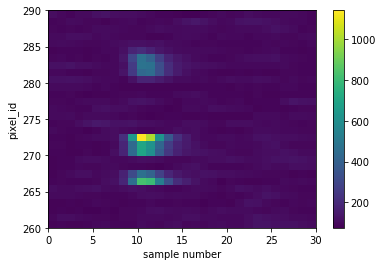

In [16]:
plt.pcolormesh(teldata.waveform[0])
plt.colorbar()
plt.ylim(260,290)
plt.xlabel("sample number")
plt.ylabel("pixel_id")
print("waveform[0] is an array of shape (N_pix,N_slice) =",teldata.waveform[0].shape)

Now we can really see that some pixels have a signal in them!

Lets look at a 1D plot of pixel 270 in channel 0 and see the signal:

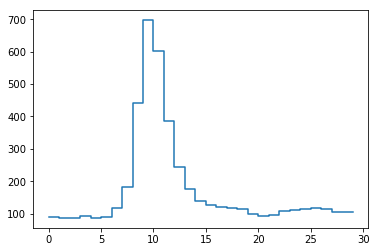

In [17]:
trace = teldata.waveform[0][270]   
plt.plot(trace, ls='steps')

Great! It looks like a *standard Cherenkov signal*!

Let's take a look at several traces to see if the peaks area aligned:

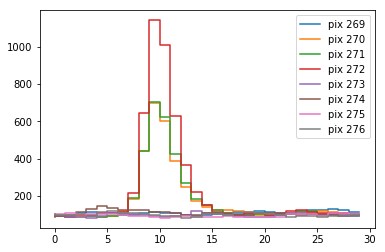

In [18]:
for pix_id in [269,270,271,272,273,274,275,276]:
    plt.plot(teldata.waveform[0][pix_id], label="pix {}".format(pix_id), ls='steps')
plt.legend()

# Next, we will do a very simple trace-integration and calculate  noise pedestals:

Let's define the integration windows first:
By eye, they seem to be reaonsable from sample 8 to 13 for signal, and 20 to 29 for pedestal (which we define as the sum of all noise: NSB + electronic)

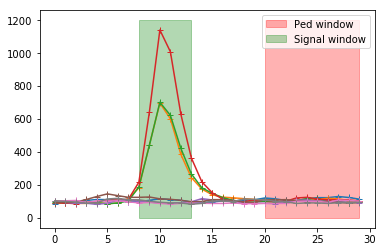

In [19]:
for pix_id in [269,270,271,272,273,274,275,276]:
    plt.plot(teldata.waveform[0][pix_id],'+-')
plt.fill_betweenx([0,1200],20,29,color='red',alpha=0.3, label='Ped window')
plt.fill_betweenx([0,1200],8,13,color='green',alpha=0.3, label='Signal window')
plt.legend()

## Very simplisitic trace analysis:
Now, let's for example calculate a signal and background in a the fixed windows we defined for this single event.  Note we are ignoring the fact that cameras have 2 gains, and just using a single gain (channel 0, which is the high-gain channel):

In [20]:
data = teldata.waveform[0]
peds = data[:, 20:29].mean(axis=1)  # mean of samples 20 to 29 for all pixels
sums = data[:, 8:13].sum(axis=1)/(13-8)    # simple sum integration

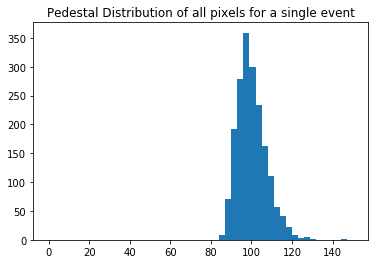

In [21]:
phist = plt.hist(peds, bins=50, range=[0,150])
plt.title("Pedestal Distribution of all pixels for a single event")

let's now take a look at the pedestal-subtracted sums and a pedestal-subtracted signal:


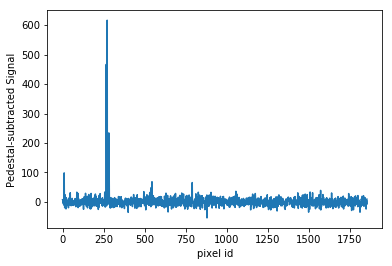

In [22]:
plt.plot(sums - peds)
plt.xlabel("pixel id")
plt.ylabel("Pedestal-subtracted Signal")

Now, we can clearly see that the signal is centered at 0 where there is no Cherenkov light, and we can also clearly see the shower around pixel 250.

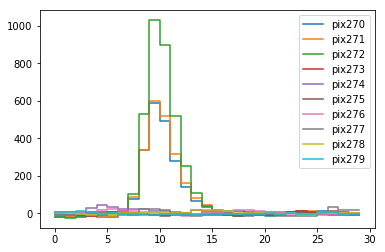

In [23]:
# we can also subtract the pedestals from the traces themselves, which would be needed to compare peaks properly
for ii in range(270,280):
    plt.plot(data[ii] - peds[ii], ls='steps', label="pix{}".format(ii))
plt.legend()

## camera displays

It's of course much easier to see the signal if we plot it in 2D with correct pixel positions! 

>note: the instrument data model is not fully implemented, so there is not a good way to load all the camera information (right now it is hacked into the `inst` sub-container that is read from the Monte-Carlo file)

In [25]:
camgeom = event.inst.subarray.tel[24].camera

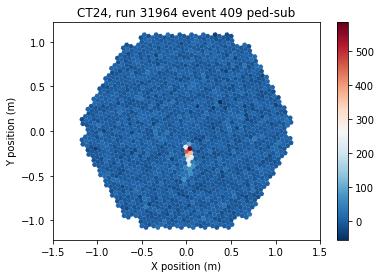

In [26]:
title="CT24, run {} event {} ped-sub".format(event.r0.obs_id,event.r0.event_id)
disp = CameraDisplay(camgeom,title=title)
disp.image = sums - peds 
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)  # autoscale

It looks like a nice signal! We have plotted our pedestal-subtracted trace integral, and see the shower clearly!

Let's look at all telescopes:

> note we plot here the raw signal, since we have not calculated the pedestals for each)

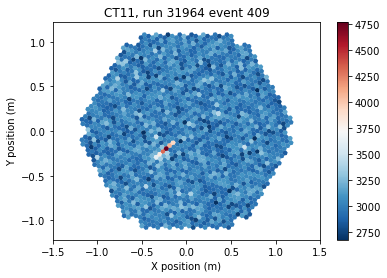

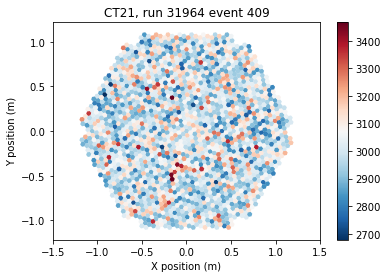

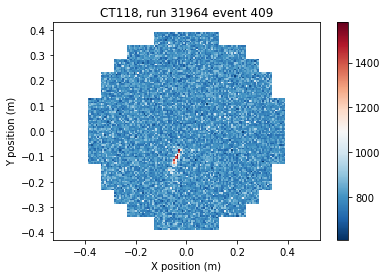

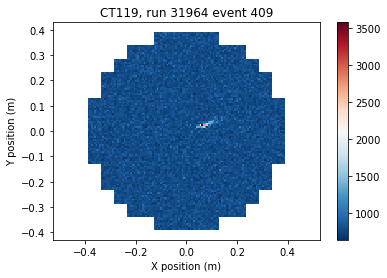

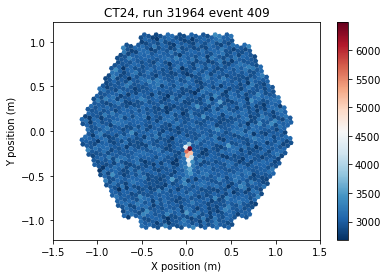

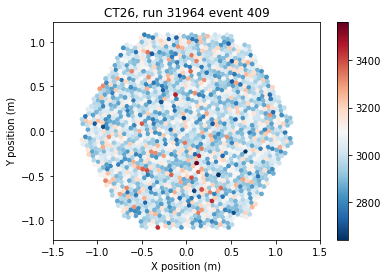

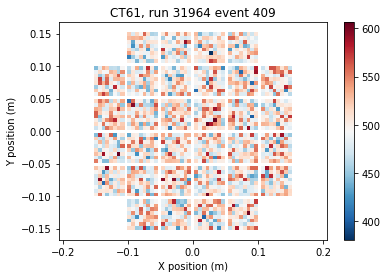

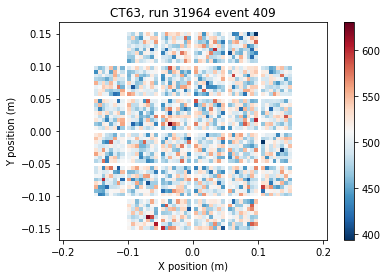

In [27]:
for tel in event.r0.tels_with_data:
    plt.figure()
    camgeom = event.inst.subarray.tel[tel].camera
    title="CT{}, run {} event {}".format(tel,event.r0.obs_id,event.r0.event_id)
    disp = CameraDisplay(camgeom,title=title)
    disp.image = event.r0.tel[tel].image[0]
    disp.cmap = plt.cm.RdBu_r
    disp.add_colorbar()
    disp.set_limits_percent(95)

# some signal processing...

Let's try to detect the peak using the scipy.signal package:
http://docs.scipy.org/doc/scipy/reference/signal.html

In [28]:
from scipy import signal
import numpy as np

pix266 has peaks at sample [11]
pix267 has peaks at sample [11 27]
pix270 has peaks at sample [11 28]
pix271 has peaks at sample [11 28]
pix272 has peaks at sample [11]
pix281 has peaks at sample [11 28]
pix282 has peaks at sample [11 28]
pix283 has peaks at sample [11 27]


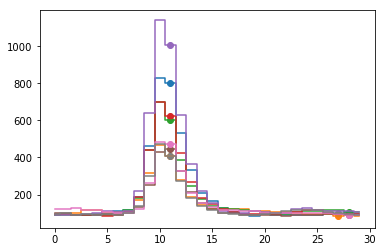

In [29]:
pix_ids = np.arange(len(data))
has_signal = sums > 300

widths = np.array([8,]) # peak widths to search for (let's fix it at 8 samples, about the width of the peak)
peaks = [signal.find_peaks_cwt(trace,widths) for trace in data[has_signal] ]

for p,s in zip(pix_ids[has_signal],peaks):
    print("pix{} has peaks at sample {}".format(p,s))
    plt.plot(data[p], ls='steps-mid')
    plt.scatter(np.array(s),data[p,s])

clearly the signal needs to be filtered first, or an appropriate wavelet used, but the idea is nice